In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
#tf.compat.v1.enable_eager_execution()

from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import random

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *

from definitions.generator.aparent_deconv_conv_generator_concat_trainmode import load_generator_network
from definitions.predictor.aparent import load_saved_predictor

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors

from scipy.stats import norm

from genesis.vae import *

def set_seed(seed_value) :
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)

def load_data(data_name, valid_set_size=0.05, test_set_size=0.05, batch_size=32) :
    
    #Load cached dataframe
    cached_dict = pickle.load(open(data_name, 'rb'))
    plasmid_df = cached_dict['plasmid_df']
    plasmid_cuts = cached_dict['plasmid_cuts']

    #print("len(plasmid_df) = " + str(len(plasmid_df)) + " (loaded)")

    #Generate training and test set indexes
    plasmid_index = np.arange(len(plasmid_df), dtype=np.int)

    plasmid_train_index = plasmid_index[:-int(len(plasmid_df) * (valid_set_size + test_set_size))]
    plasmid_valid_index = plasmid_index[plasmid_train_index.shape[0]:-int(len(plasmid_df) * test_set_size)]
    plasmid_test_index = plasmid_index[plasmid_train_index.shape[0] + plasmid_valid_index.shape[0]:]

    #print('Training set size = ' + str(plasmid_train_index.shape[0]))
    #print('Validation set size = ' + str(plasmid_valid_index.shape[0]))
    #print('Test set size = ' + str(plasmid_test_index.shape[0]))


    data_gens = {
        gen_id : iso.DataGenerator(
            idx,
            {'df' : plasmid_df},
            batch_size=batch_size,
            inputs = [
                {
                    'id' : 'seq',
                    'source_type' : 'dataframe',
                    'source' : 'df',
                    'extractor' : lambda row, index: row['padded_seq'][180 + 40: 180 + 40 + 81] + "G" * (128-81),
                    'encoder' : iso.OneHotEncoder(seq_length=128),
                    'dim' : (1, 128, 4),
                    'sparsify' : False
                }
            ],
            outputs = [
                {
                    'id' : 'dummy_output',
                    'source_type' : 'zeros',
                    'dim' : (1,),
                    'sparsify' : False
                }
            ],
            randomizers = [],
            shuffle = True if gen_id == 'train' else False
        ) for gen_id, idx in [('all', plasmid_index), ('train', plasmid_train_index), ('valid', plasmid_valid_index), ('test', plasmid_test_index)]
    }

    x_train = np.concatenate([data_gens['train'][i][0][0] for i in range(len(data_gens['train']))], axis=0)
    x_test = np.concatenate([data_gens['test'][i][0][0] for i in range(len(data_gens['test']))], axis=0)
    
    return x_train, x_test


Using TensorFlow backend.


In [2]:
#Specfiy problem-specific parameters

experiment_suffix = '_strong_vae_very_high_kl_epoch_35_lower_fitness'

vae_model_prefix = "vae/saved_models/vae_apa_max_isoform_doubledope_strong_cano_pas_len_128_50_epochs_very_high_kl"
vae_model_suffix = "_epoch_35"#""#

#VAE model path
saved_vae_encoder_model_path = vae_model_prefix + "_encoder" + vae_model_suffix + ".h5"
saved_vae_decoder_model_path = vae_model_prefix + "_decoder" + vae_model_suffix + ".h5"

#Padding for the VAE
vae_upstream_padding = ''
vae_downstream_padding = 'G' * 47

#VAE sequence template
vae_sequence_template = 'ATCCANNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCC' + 'G' * (128 - 81)

#VAE latent dim
vae_latent_dim = 100

#Oracle predictor model path
saved_predictor_model_path = '../../../aparent/saved_models/aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'

#Subtring indices for VAE
vae_pwm_start = 40
vae_pwm_end = 121

#VAE parameter collection
vae_params = [
    saved_vae_encoder_model_path,
    saved_vae_decoder_model_path,
    vae_upstream_padding,
    vae_downstream_padding,
    vae_latent_dim,
    vae_pwm_start,
    vae_pwm_end
]

#Load data set
vae_data_path = "vae/apa_doubledope_cached_set_strong_short_cano_pas.pickle"

_, x_test = load_data(vae_data_path, valid_set_size=0.005, test_set_size=0.095)


mean log(likelihood) = -38.70989728805291


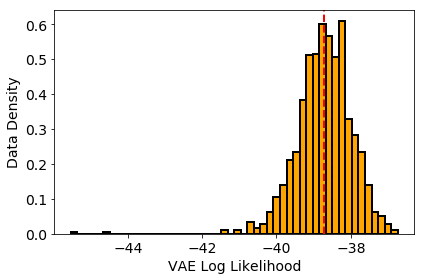

In [5]:
#Evaluate ELBO distribution on test set

#Load VAE models
vae_encoder_model = load_model(saved_vae_encoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})
vae_decoder_model = load_model(saved_vae_decoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})

#Compute multi-sample ELBO on test set
log_mean_p_vae_test, mean_log_p_vae_test, log_p_vae_test = evaluate_elbo(vae_encoder_model, vae_decoder_model, x_test, n_samples=128)

print("mean log(likelihood) = " + str(mean_log_p_vae_test))

#Log Likelihood Plot
plot_min_val = None
plot_max_val = None

f = plt.figure(figsize=(6, 4))

log_p_vae_test_hist, log_p_vae_test_edges = np.histogram(log_mean_p_vae_test, bins=50, density=True)
bin_width_test = log_p_vae_test_edges[1] - log_p_vae_test_edges[0]

plt.bar(log_p_vae_test_edges[1:] - bin_width_test/2., log_p_vae_test_hist, width=bin_width_test, linewidth=2, edgecolor='black', color='orange')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if plot_min_val is not None and plot_max_val is not None :
    plt.xlim(plot_min_val, plot_max_val)

plt.xlabel("VAE Log Likelihood", fontsize=14)
plt.ylabel("Data Density", fontsize=14)

plt.axvline(x=mean_log_p_vae_test, linewidth=2, color='red', linestyle="--")

plt.tight_layout()
plt.show()


mean log(likelihood) = -38.80713871551151


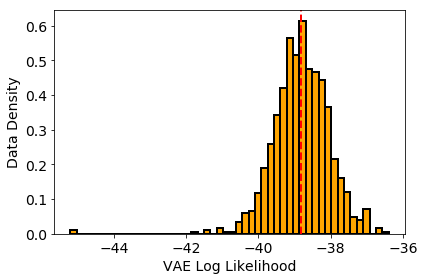

In [6]:
#Evaluate ELBO distribution on test set (training-level no. of samples)

#Load VAE models
vae_encoder_model = load_model(saved_vae_encoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})
vae_decoder_model = load_model(saved_vae_decoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})

#Compute multi-sample ELBO on test set
log_mean_p_vae_test, mean_log_p_vae_test, log_p_vae_test = evaluate_elbo(vae_encoder_model, vae_decoder_model, x_test, n_samples=32)

print("mean log(likelihood) = " + str(mean_log_p_vae_test))

#Log Likelihood Plot
plot_min_val = None
plot_max_val = None

f = plt.figure(figsize=(6, 4))

log_p_vae_test_hist, log_p_vae_test_edges = np.histogram(log_mean_p_vae_test, bins=50, density=True)
bin_width_test = log_p_vae_test_edges[1] - log_p_vae_test_edges[0]

plt.bar(log_p_vae_test_edges[1:] - bin_width_test/2., log_p_vae_test_hist, width=bin_width_test, linewidth=2, edgecolor='black', color='orange')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if plot_min_val is not None and plot_max_val is not None :
    plt.xlim(plot_min_val, plot_max_val)

plt.xlabel("VAE Log Likelihood", fontsize=14)
plt.ylabel("Data Density", fontsize=14)

plt.axvline(x=mean_log_p_vae_test, linewidth=2, color='red', linestyle="--")

plt.tight_layout()
plt.show()


In [6]:
#Load models

#Load VAE models
vae_encoder_model = load_model(saved_vae_encoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})
vae_decoder_model = load_model(saved_vae_decoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})

predictor_model = load_model(saved_predictor_model_path)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [7]:
#Setup predictor function
libraries = ['tomm5_up_n20c20_dn_c20', 'tomm5_up_c20n20_dn_c20', 'tomm5_up_n20c20_dn_n20', 'tomm5_up_c20n20_dn_n20', 'doubledope', 'simple', 'atr', 'hsp', 'snh', 'sox', 'wha', 'array', 'aar']
library_dict = { lib : i for i, lib in enumerate(libraries) }

lib_ix = library_dict['doubledope']

predictor_upstream_padding = "CTTCCGATCTCTCGCTCTTTCTATGGCATTCATTACTCGC"
predictor_downstream_padding = "AATTAAGCCTGTCGTCGTGGGTGTCGAAAATGAAATAAAACAAGTCAATTGCGTAGTTTATTCAGACGTACCCCGTGGACCTAC"
predictor_pwm_start = 0
predictor_pwm_end = 5 + 71 + 5

predictor_upstream_padding_one_hots = None
if len(predictor_upstream_padding) > 0 :
    predictor_upstream_padding_one_hots = one_hot_encode(predictor_upstream_padding, n=1, singleton_axis=-1)

predictor_downstream_padding_one_hots = None
if len(predictor_downstream_padding) > 0 :
    predictor_downstream_padding_one_hots = one_hot_encode(predictor_downstream_padding, n=1, singleton_axis=-1)

#Predict fitness score
def _predict_func(sequence_one_hots, predictor_model, lib_ix=lib_ix) :
    x_1 = np.moveaxis(sequence_one_hots, 1, -1)[:, predictor_pwm_start:predictor_pwm_end, :, :]
    
    if len(predictor_upstream_padding) > 0 :
        x_1 = np.concatenate([np.tile(predictor_upstream_padding_one_hots, (x_1.shape[0], 1, 1, 1)), x_1], axis=1)
    
    if len(predictor_downstream_padding) > 0 :
        x_1 = np.concatenate([x_1, np.tile(predictor_downstream_padding_one_hots, (x_1.shape[0], 1, 1, 1))], axis=1)
    
    x_2 = np.zeros((sequence_one_hots.shape[0], 13))
    x_2[:, lib_ix] = 1.
    x_3 = np.ones((sequence_one_hots.shape[0], 1))
    
    iso_pred, _ = predictor_model.predict(x=[x_1, x_2, x_3], batch_size=32, verbose=False)
    
    logodds_pred = np.log(iso_pred[:, 0] / (1. - iso_pred[:, 0]))
    
    return logodds_pred


In [8]:
#Evaluate ELBOs
n_z_samples = 128
n = 1024

#Evaluate VAE Likelihood on test data

log_mean_p_vae_test, mean_log_p_vae_test, _ = evaluate_elbo(vae_encoder_model, vae_decoder_model, x_test[:n], n_samples=n_z_samples)
fitness_score_test = _predict_func(x_test, predictor_model)

#Evaluate VAE Likelihood on random data

x_random = np.zeros((n, 1, 128, 4))
for i in range(n) :
    random_seq = ''
    for j in range(len(vae_sequence_template)) :
        if vae_sequence_template[j] == 'N' :
            rand_letter = np.random.choice(['A', 'C', 'G', 'T'], replace=False)
            random_seq += rand_letter
        else :
            random_seq += vae_sequence_template[j]
    
    for j in range(len(random_seq)) :
        if random_seq[j] == 'A' :
            x_random[i, 0, j, 0] = 1.
        elif random_seq[j] == 'C' :
            x_random[i, 0, j, 1] = 1.
        elif random_seq[j] == 'G' :
            x_random[i, 0, j, 2] = 1.
        elif random_seq[j] == 'T' :
            x_random[i, 0, j, 3] = 1.

log_mean_p_vae_random, mean_log_p_vae_random, _ = evaluate_elbo(vae_encoder_model, vae_decoder_model, x_random, n_samples=n_z_samples)
fitness_score_random = _predict_func(x_random, predictor_model)


In [12]:

batch_size = 64

experiment_suffixes = [
    '_strong_vae_very_high_kl_epoch_35_margin_neg_2_lower_fitness',
    '_strong_vae_very_high_kl_epoch_35_margin_0_lower_fitness',
    '_strong_vae_very_high_kl_epoch_35_margin_pos_2_lower_fitness',
    '_weak_vae_very_high_kl_epoch_35_only_fitness',
]

#Evaluate VAE Likelihood on generated data

log_mean_p_vae_new_dict = {}
mean_log_p_vae_new_dict = {}
fitness_score_new_dict = {}

for temp_ix, temp_suffix in enumerate(experiment_suffixes) :

    print("Evaluating on genesis" + temp_suffix + ".")
    
    den_name = 'genesis_apa_max_isoform_doubledope' + temp_suffix + '_vae_kl'
    den_model = load_model("saved_models/" + den_name + "_predictor.h5", custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})

    sequence_class = np.array([0] * n).reshape(-1, 1) #np.random.uniform(-6, 6, (n, 1)) #

    noise_1 = np.random.uniform(-1, 1, (n, 100))
    noise_2 = np.random.uniform(-1, 1, (n, 100))

    sampled_sequences_new = den_model.predict([sequence_class, noise_1, noise_2], batch_size=batch_size, verbose=False)[5]
    sampled_sequences_new = np.moveaxis(sampled_sequences_new[:, 0, ...], 3, 1)

    x_new = np.concatenate([
        one_hot_encode(vae_upstream_padding, n=n, singleton_axis=1),
        sampled_sequences_new[:, :, vae_pwm_start:vae_pwm_end, :],
        one_hot_encode(vae_downstream_padding, n=n, singleton_axis=1)
    ], axis=2)

    log_mean_p_vae_new, mean_log_p_vae_new, _ = evaluate_elbo(vae_encoder_model, vae_decoder_model, x_new, n_samples=n_z_samples)
    fitness_score_new = _predict_func(x_new, predictor_model)
    
    log_mean_p_vae_new_dict[temp_suffix] = log_mean_p_vae_new
    mean_log_p_vae_new_dict[temp_suffix] = mean_log_p_vae_new
    fitness_score_new_dict[temp_suffix] = fitness_score_new


Evaluating on genesis_weak_vae_very_high_kl_epoch_35_only_fitness.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [13]:

likelihood_histos = [
    log_mean_p_vae_test,
    log_mean_p_vae_new_dict['_strong_vae_very_high_kl_epoch_35_margin_neg_2_lower_fitness'],
    log_mean_p_vae_new_dict['_strong_vae_very_high_kl_epoch_35_margin_0_lower_fitness'],
    log_mean_p_vae_new_dict['_strong_vae_very_high_kl_epoch_35_margin_pos_2_lower_fitness'],
    log_mean_p_vae_new_dict['_weak_vae_very_high_kl_epoch_35_only_fitness']
]

fitness_histos = [
    fitness_score_test,
    fitness_score_new_dict['_strong_vae_very_high_kl_epoch_35_margin_neg_2_lower_fitness'],
    fitness_score_new_dict['_strong_vae_very_high_kl_epoch_35_margin_0_lower_fitness'],
    fitness_score_new_dict['_strong_vae_very_high_kl_epoch_35_margin_pos_2_lower_fitness'],
    fitness_score_new_dict['_weak_vae_very_high_kl_epoch_35_only_fitness']
]

name_list = [
    'Test',
    '-2',
    '0',
    '+2',
    'Fitness'
]

color_list = [
    'orange',
    'whitesmoke',
    'silver',
    'dimgray',
    'black'
]


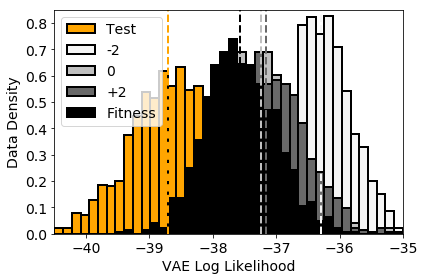

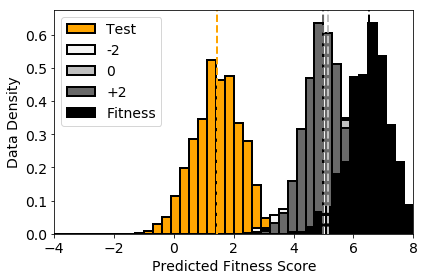

In [19]:
#Joint histograms

#Compare VAE Log Likelihoods (ELBO)
plot_joint_histo(
    likelihood_histos,
    name_list,
    color_list,
    'VAE Log Likelihood',
    'Data Density',
    min_val=-40.5,
    max_val=-35,
    max_y_val=0.85,
    n_bins=40,
    figsize=(6, 4),
    save_fig=True,
    fig_name="apa_doubledope_" + experiment_suffix + "_likelihood"
)


#Compare Fitness Scores
plot_joint_histo(
    fitness_histos,
    name_list,
    color_list,
    'Predicted Fitness Score',
    'Data Density',
    min_val=-4,
    max_val=8,
    max_y_val=0.675,
    n_bins=40,
    figsize=(6, 4),
    save_fig=True,
    fig_name="apa_doubledope_" + experiment_suffix + "_fitness"
)


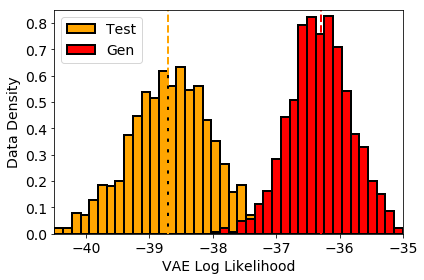

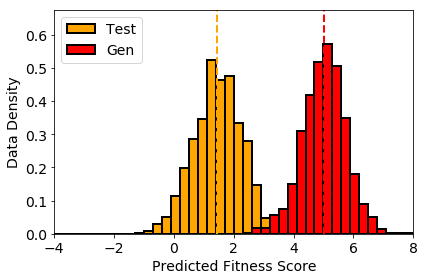

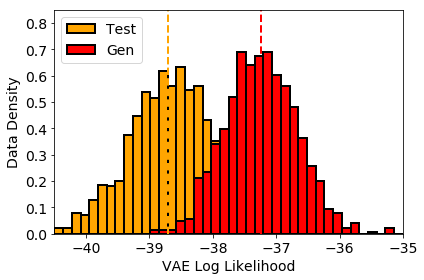

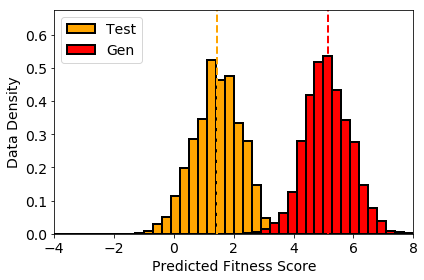

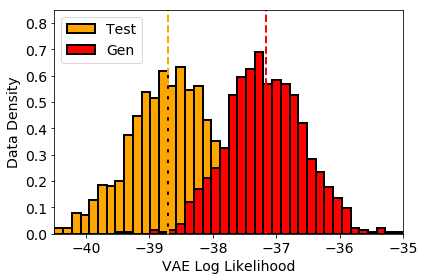

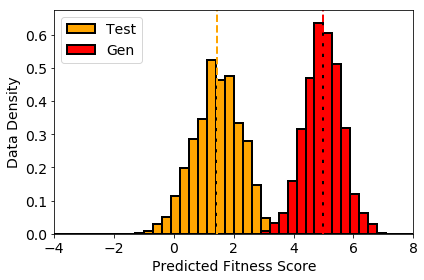

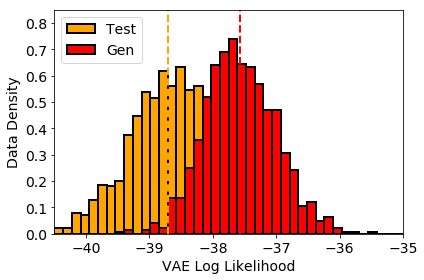

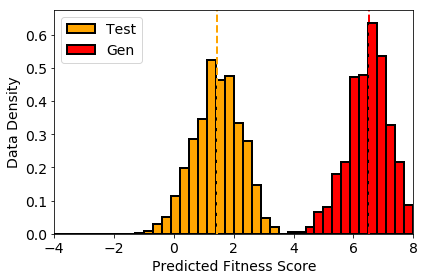

In [22]:
#Individual histograms

for temp_ix, temp_suffix in enumerate(experiment_suffixes) :
    log_mean_p_vae_new = log_mean_p_vae_new_dict[temp_suffix]
    mean_log_p_vae_new = mean_log_p_vae_new_dict[temp_suffix]
    fitness_score_new = fitness_score_new_dict[temp_suffix]

    #Compare VAE Log Likelihoods (ELBO)
    plot_joint_histo(
        [log_mean_p_vae_test, log_mean_p_vae_new],
        ['Test', 'Gen'],
        ['orange', 'red'],
        'VAE Log Likelihood',
        'Data Density',
        min_val=-40.5,
        max_val=-35,
        max_y_val=0.85,
        n_bins=40,
        figsize=(6, 4),
        save_fig=True,
        fig_name="apa_doubledope_" + temp_suffix + "_likelihood"
    )


    #Compare Fitness Scores
    plot_joint_histo(
        [fitness_score_test, fitness_score_new],
        ['Test', 'Gen'],
        ['orange', 'red'],
        'Predicted Fitness Score',
        'Data Density',
        min_val=-4,
        max_val=8,
        max_y_val=0.675,
        n_bins=40,
        figsize=(6, 4),
        save_fig=True,
        fig_name="apa_doubledope_" + temp_suffix + "_fitness"
    )
